In [1]:
import pandas as pd
import numpy as np
from janitor import clean_names
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import recall_score, precision_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV

from xgboost import XGBClassifier

let's set a seed for reproducibility

In [2]:
seed = 42

In [3]:
df = pd.read_csv("CustomerData_LeadGenerator.csv")
df.columns

Index(['fakeID', 'b_specialisation_i', 'b_specialisation_h',
       'b_specialisation_g', 'b_specialisation_f', 'b_specialisation_e',
       'b_specialisation_d', 'b_specialisation_c', 'b_specialisation_b',
       'b_specialisation_a', 'b_specialisation_j', 'q_OpeningDays',
       'q_OpeningHours', 'q_2017 Average Household Size',
       'q_2017 Total Households',
       'q_2017 HHs: 5th Quintile (68.759 and above)',
       'q_5th Quint by Total HH', 'q_2017 Purchasing Power: Per Capita',
       'q_2017 Total Population',
       'q_2017 Pop 15+/Edu: University, Fachhochschule', 'q_Uni by Total Pop',
       'q_2017 Personal Care: Per Capita',
       'q_2017 Medical Products: Per Capita',
       'q_2017 Personal Effects: Per Capita', 'b_in_kontakt_gewesen',
       'b_gekauft_gesamt'],
      dtype='object')

column names contain special characters. let's clean them up

In [4]:
df = clean_names(df, strip_underscores=True, remove_special=True)
df.columns

Index(['fakeid', 'b_specialisation_i', 'b_specialisation_h',
       'b_specialisation_g', 'b_specialisation_f', 'b_specialisation_e',
       'b_specialisation_d', 'b_specialisation_c', 'b_specialisation_b',
       'b_specialisation_a', 'b_specialisation_j', 'q_openingdays',
       'q_openinghours', 'q_2017_average_household_size',
       'q_2017_total_households', 'q_2017_hhs_5th_quintile_68_759_and_above',
       'q_5th_quint_by_total_hh', 'q_2017_purchasing_power_per_capita',
       'q_2017_total_population',
       'q_2017_pop_15_edu_university_fachhochschule', 'q_uni_by_total_pop',
       'q_2017_personal_care_per_capita', 'q_2017_medical_products_per_capita',
       'q_2017_personal_effects_per_capita', 'b_in_kontakt_gewesen',
       'b_gekauft_gesamt'],
      dtype='object')

let's take a brief look at the data

In [5]:
pd.set_option('display.max_columns', None)
df.head()

,fakeid,b_specialisation_i,b_specialisation_h,b_specialisation_g,b_specialisation_f,b_specialisation_e,b_specialisation_d,b_specialisation_c,b_specialisation_b,b_specialisation_a,b_specialisation_j,q_openingdays,q_openinghours,q_2017_average_household_size,q_2017_total_households,q_2017_hhs_5th_quintile_68_759_and_above,q_5th_quint_by_total_hh,q_2017_purchasing_power_per_capita,q_2017_total_population,q_2017_pop_15_edu_university_fachhochschule,q_uni_by_total_pop,q_2017_personal_care_per_capita,q_2017_medical_products_per_capita,q_2017_personal_effects_per_capita,b_in_kontakt_gewesen,b_gekauft_gesamt
0,1069_7334,0,0,0,0,0,0,0,0,0,1,4,36,2.1,1045481,195228,0.186735,23730.35,2194057,324656,0.147971,593.19,326.28,235.75,1,1
1,328_2350,0,0,0,1,1,1,0,0,0,0,4,20,2.1,935739,168291,0.179848,23343.26,1966798,281130,0.142938,588.54,320.36,230.66,1,1
2,865_6285,0,0,0,1,0,1,0,0,0,1,0,0,2.1,1026235,189787,0.184935,23674.18,2149624,320326,0.149015,592.88,325.57,234.82,1,1
3,47_307,0,1,1,0,0,0,0,0,0,0,4,20,2.1,1027701,189634,0.184523,23572.26,2161445,310981,0.143876,590.84,324.06,233.81,1,0
4,342_2513,0,0,0,0,0,1,0,0,0,1,5,33,2.1,1093324,207590,0.189871,23821.63,2302959,334940,0.145439,593.56,327.75,237.41,1,1


let's take a look at the descriptive statistics

In [6]:
df.describe()

,b_specialisation_i,b_specialisation_h,b_specialisation_g,b_specialisation_f,b_specialisation_e,b_specialisation_d,b_specialisation_c,b_specialisation_b,b_specialisation_a,b_specialisation_j,q_openingdays,q_2017_average_household_size,q_2017_total_households,q_2017_hhs_5th_quintile_68_759_and_above,q_5th_quint_by_total_hh,q_2017_purchasing_power_per_capita,q_2017_total_population,q_2017_pop_15_edu_university_fachhochschule,q_uni_by_total_pop,q_2017_personal_care_per_capita,q_2017_medical_products_per_capita,q_2017_personal_effects_per_capita,b_in_kontakt_gewesen,b_gekauft_gesamt
count,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3.773000e+03,3773.000000,3773.000000,3773.000000,3.773000e+03,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000
mean,0.218129,0.224225,0.254704,0.111582,0.285449,0.005566,0.002650,0.020408,0.138616,0.254174,3.230586,2.242221,3.873879e+05,73575.237477,0.197419,23170.651983,8.257315e+05,111252.936920,0.101737,574.247339,326.438110,234.848630,0.025179,0.015107
std,0.413030,0.417126,0.435753,0.314894,0.451688,0.074407,0.051421,0.141411,0.345592,0.435454,2.070304,0.153143,4.116316e+05,75533.849191,0.024973,1147.978703,8.565966e+05,131837.721022,0.039749,22.966321,11.135183,11.018168,0.156689,0.121996
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.718000e+03,316.000000,0.100814,19171.140000,3.807000e+03,172.000000,0.027974,490.390000,270.110000,196.450000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.100000,7.571800e+04,15441.000000,0.184566,22662.050000,1.780610e+05,11431.000000,0.063095,560.130000,322.380000,231.310000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.200000,1.537120e+05,34165.000000,0.195882,23627.240000,3.417850e+05,39282.000000,0.101592,584.000000,325.860000,235.290000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,2.400000,9.651600e+05,174038.000000,0.213667,23839.540000,2.023342e+06,298968.000000,0.145630,592.520000,331.930000,238.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,2.900000,1.113261e+06,212126.000000,0.269397,26008.530000,2.350279e+06,337338.000000,0.170786,610.140000,363.230000,274.140000,1.000000,1.000000


In [7]:
df[['b_in_kontakt_gewesen', 'b_gekauft_gesamt']] \
    .value_counts(normalize=True) \
    .reset_index(name='count')

,b_in_kontakt_gewesen,b_gekauft_gesamt,count
0,0,0,0.974821
1,1,1,0.015107
2,1,0,0.010072


Lead generation is a marketing problem where the goal is to identify customers that will potentially make a purchase. Once those customers are identified the marketing department will pursue them for conversion. Identifying potential customers can be done through a machine learning model, where the model is training on historical of customers that made and did not make a purchase. As such the target variable in our dataset is "b_gekauft_gesamt", which is a binary variable indicating whether the customer made a purchase or not. The given dataset is highly imbalanced with the 98.5 percent of the target values belonging to the negative class.

The metric we need to optimize is recall: how many of the actual hits the model correctly predicts as being likely hits.

Furthermore, the dataset contains binary variable "b_in_kontakt_gewesen", which indicates whether the customers has been contacted. As we can see from the table above, none of the customers that were not contacted did not make a purchase. I will drop this variable from the modeling as my understanding is that a customer needs to be contacted once she/he is identified as a prospect (in this case as per output of the model). Furthermore, in my opinion, adding the variable to the model would introduce data leakage.

### Meaning of the variables

 - fakeid - unique id of the customer

### Demographic variables
- b_specialisation_i - whether the customer has specialization i
- b_specialisation_h - whether the customer has specialization h
- b_specialisation_g - whether the customer has specialization g
- b_specialisation_f - whether the customer has specialization f
- b_specialisation_e - whether the customer has specialization e
- b_specialisation_d - whether the customer has specialization d
- b_specialisation_c - whether the customer has specialization c
- b_specialisation_b - whether the customer has specialization b
- b_specialisation_a - whether the customer has specialization a
- b_specialisation_j - whether the customer has specialization j
  
- q_2017_average_household_size - the number of people in households divided by the number of households
- q_2017_total_households - total number of hh in the geographical area (there were 42 ml hh in Germany in 2021, so the values in the column must belong to a smaller geographical division)
- q_2017_hhs_5th_quintile_68_759_and_above
- q_5th_quint_by_total_hh
- q_2017_purchasing_power_per_capita - pp per hh?
- q_2017_total_population - total population in the geographical area
- q_2017_pop_15_edu_university_fachhochschule - population 15 years old and older enrolled at a university
- q_uni_by_total_pop - percent of the university degree holders among the total population

### Behavioral variables
- q_openingdays - number of opening days in a week
- q_openinghours - number of opening hours in a week
- q_2017_personal_care_per_capita - amount spent on personal care products (per hh?)
- q_2017_medical_products_per_capita - amount spent on medical products (per hh?)
- q_2017_personal_effects_per_capita - amount spent on personal effects (person’s personal property) (per hh?)
 
### Targets
- b_in_kontakt_gewesen - whether the customers has been contacted
- b_gekauft_gesamt - whether the customer made a purchase

In [8]:
print(
    f'number of observations: {len(df)} \n',
    f'number of unique clients: {len(set(df["fakeid"]))}'
)

number of observations: 3773 
 number of unique clients: 3773


number of unique customers matches the number of observations in the data, which means that there should be one observation per customer

### EDA

let's have a look at the variable types and if there are any missing values

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3773 entries, 0 to 3772
Data columns (total 26 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   fakeid                                       3773 non-null   object 
 1   b_specialisation_i                           3773 non-null   int64  
 2   b_specialisation_h                           3773 non-null   int64  
 3   b_specialisation_g                           3773 non-null   int64  
 4   b_specialisation_f                           3773 non-null   int64  
 5   b_specialisation_e                           3773 non-null   int64  
 6   b_specialisation_d                           3773 non-null   int64  
 7   b_specialisation_c                           3773 non-null   int64  
 8   b_specialisation_b                           3773 non-null   int64  
 9   b_specialisation_a                           3773 non-null   int64  
 10  

There is one string variable, q_openinghours, however, from the name and prefix it seems like it should be a numeric column instead. Let's check what strings are in there

In [10]:
df[df['q_openinghours'].str.contains('[a-zA-Z]')]['q_openinghours']

2099    ject
Name: q_openinghours, dtype: object

let's convert the column to numeric and double check that there was only one observation with strings in it


In [11]:
df['q_openinghours'] = pd.to_numeric(df['q_openinghours'], errors='coerce')
sum(df['q_openinghours'].isna())

1

In [12]:
float_cols = [k for (k, v) in (df.dtypes==np.float64).to_dict().items() if v==True]
specialisation_cols = [col for col in df.columns.tolist() if "b_specialisation" in col]
numeric_cols = float_cols + [
    'q_2017_total_population', 
    'q_2017_pop_15_edu_university_fachhochschule', 
    'q_2017_total_households', 
    'q_2017_hhs_5th_quintile_68_759_and_above', 
    'q_openingdays'
]

let's look at the distribution of some numeric columns across the target variable

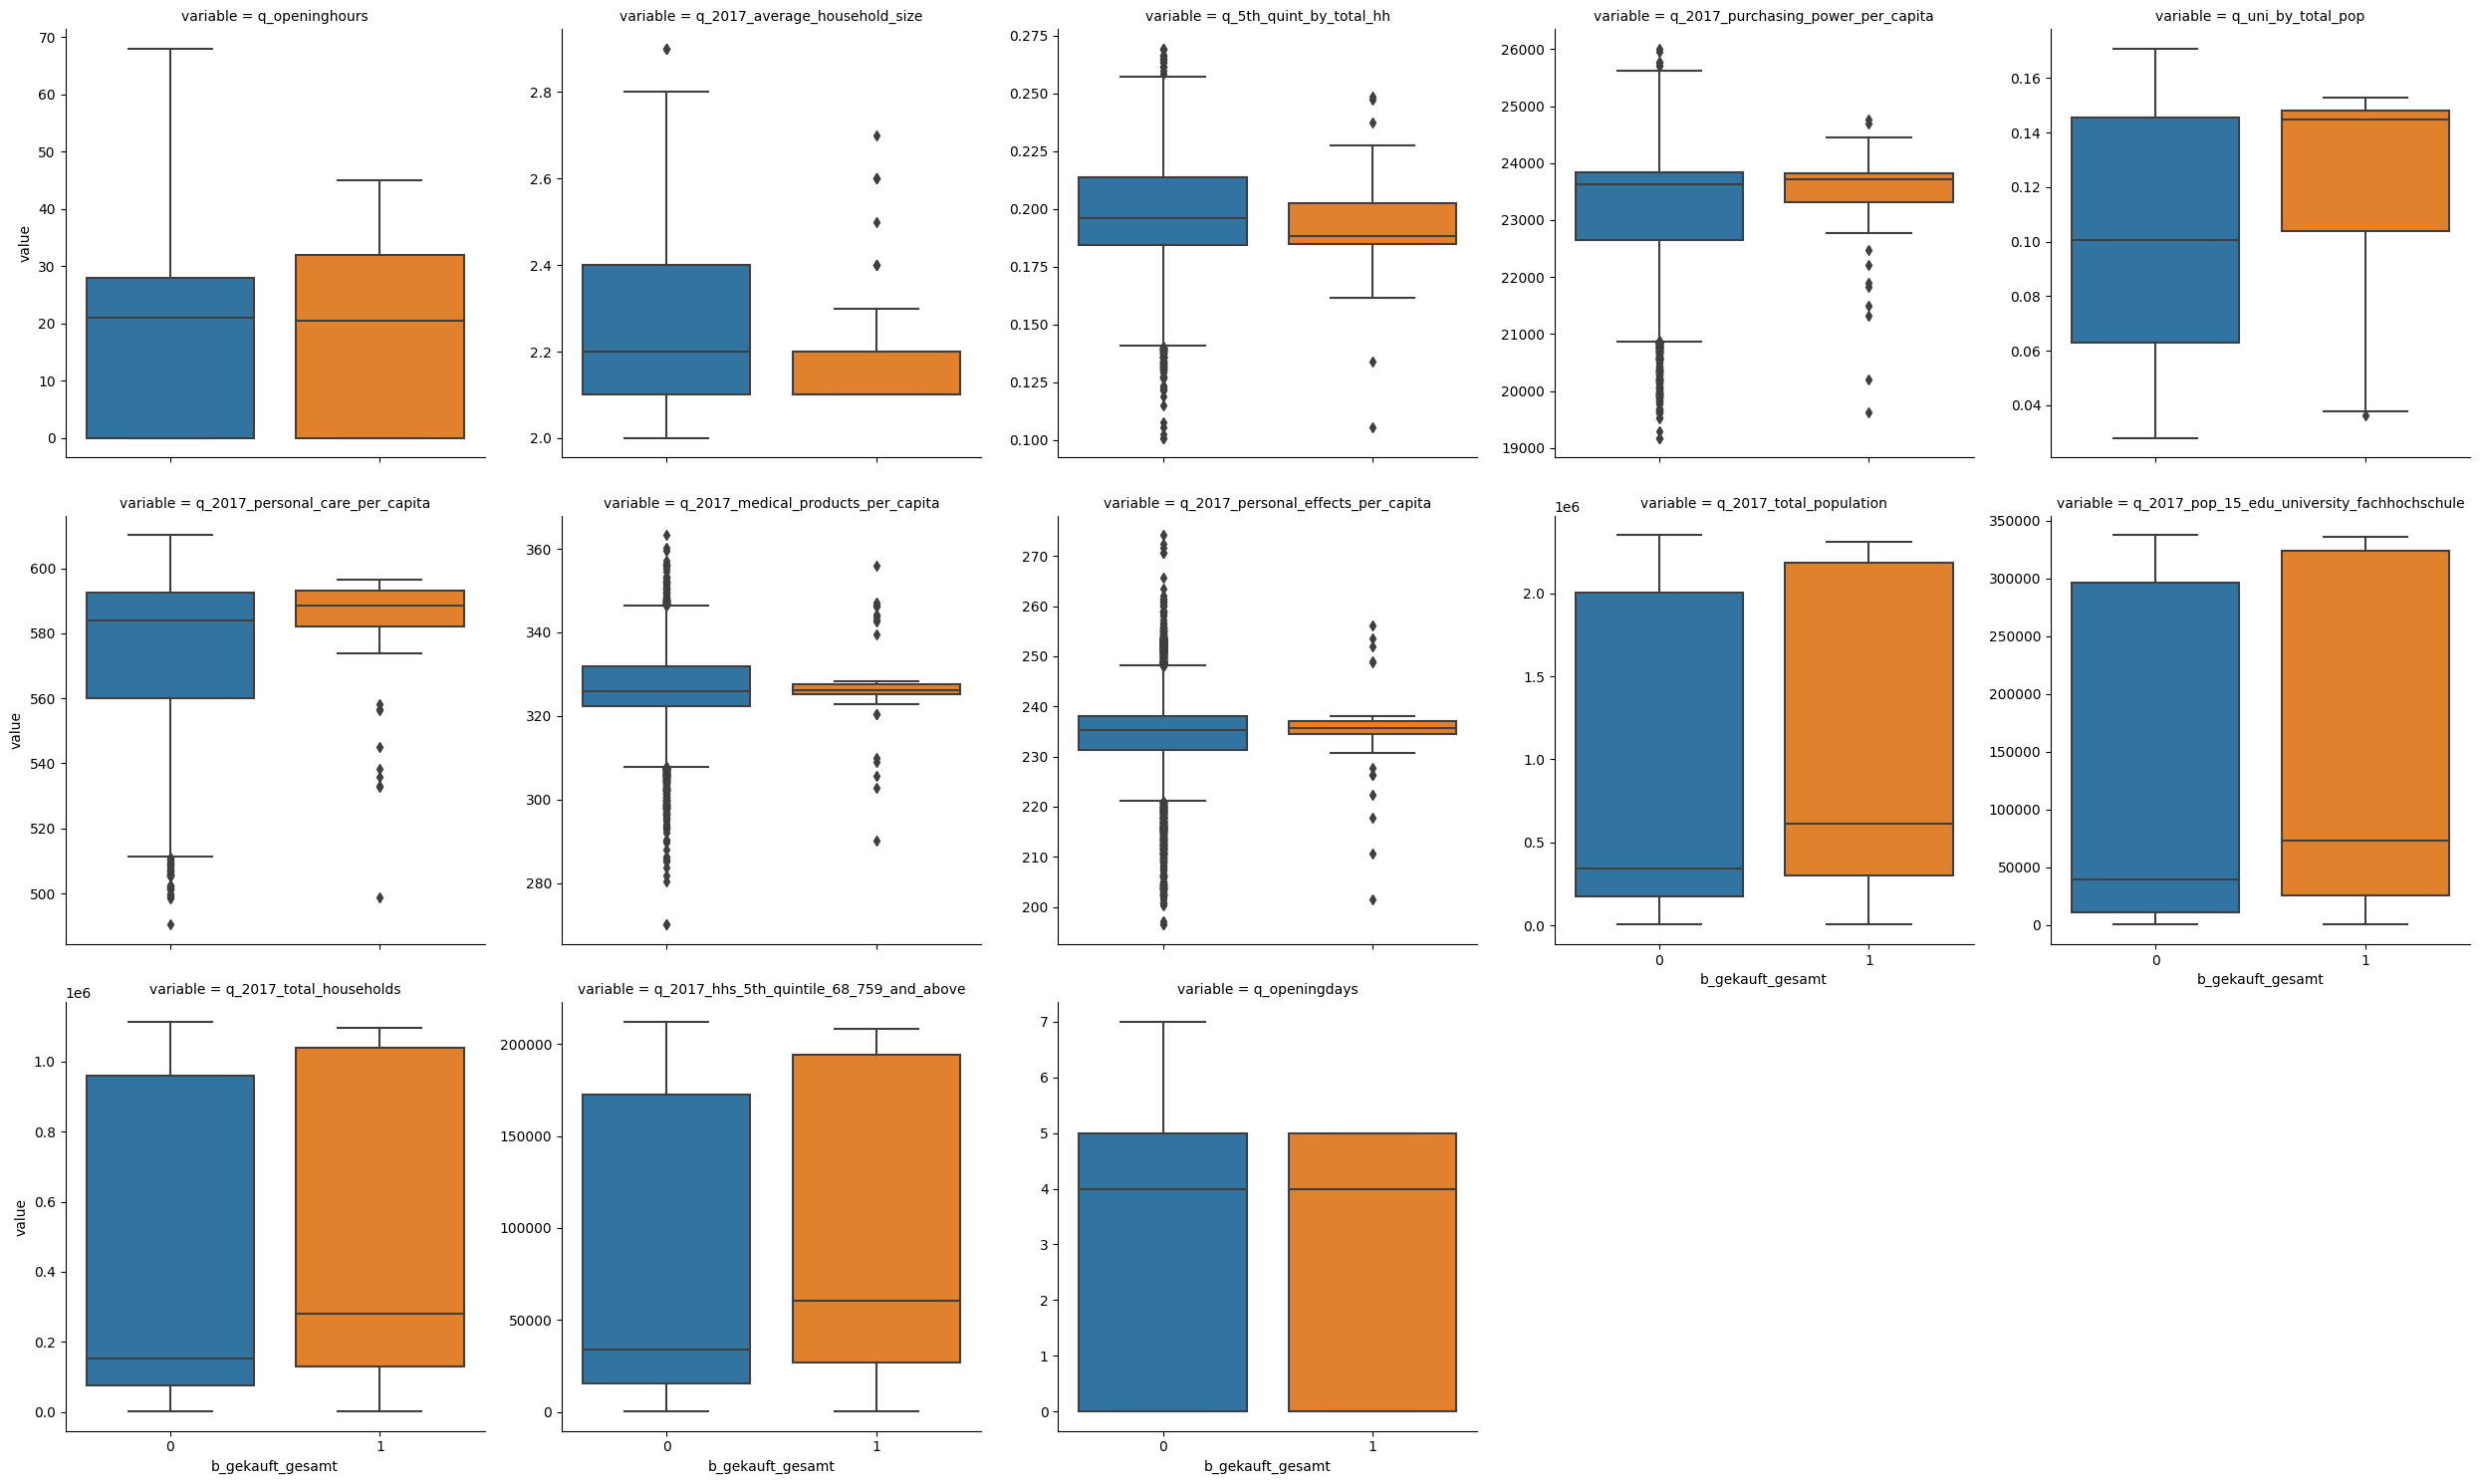

In [13]:
df[numeric_cols + ['b_gekauft_gesamt']] \
    .melt(id_vars='b_gekauft_gesamt', value_vars=numeric_cols) \
    .pipe(
        (sns.catplot, 'data'), 
        x='b_gekauft_gesamt', 
        y='value', 
        col='variable',
        kind='box', 
        sharey=False,
        col_wrap=5
    )

There don't seem to be significant differences between the features of customers that made and did not make a purchase. The median line of box plots lie inside of the box of a comparison box plot, which indicates that the groups are not that different from each other. Some noticeable differences are that certain features have larger dispersion for the customers that did not make a purchase. Particularly interesting is that there is a larger dispersion of share of uni (degree) and for purchasing power among customers that did not make a purchase.

We can also look at the scatter plot matrix to see how multiple variables are related

let's look at the shares of positive values within the specialization columns

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'b_in_kontakt_gewesen'),
  Text(1, 0, 'b_specialisation_a'),
  Text(2, 0, 'b_specialisation_b'),
  Text(3, 0, 'b_specialisation_c'),
  Text(4, 0, 'b_specialisation_d'),
  Text(5, 0, 'b_specialisation_e'),
  Text(6, 0, 'b_specialisation_f'),
  Text(7, 0, 'b_specialisation_g'),
  Text(8, 0, 'b_specialisation_h'),
  Text(9, 0, 'b_specialisation_i'),
  Text(10, 0, 'b_specialisation_j')])

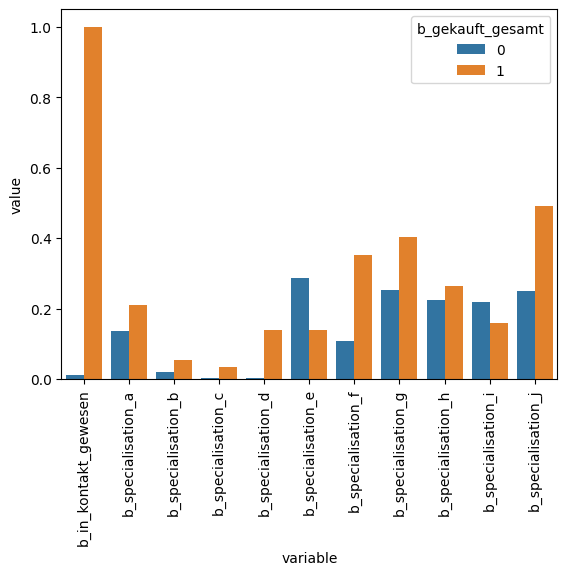

In [14]:
df[specialisation_cols + ['b_gekauft_gesamt', 'b_in_kontakt_gewesen']] \
    .groupby(['b_gekauft_gesamt']) \
    .mean() \
    .reset_index() \
    .melt(id_vars='b_gekauft_gesamt') \
    .sort_values(by='variable') \
    .pipe((sns.barplot, 'data'), x='variable', y='value', hue='b_gekauft_gesamt')

plt.xticks(rotation=90)

It seems like clients that made a purchase have more often specializations d, f, j, while customers did not make a purchase have more often specialization e. These variables could potentialy help the model identify leads

### Feature Engineering

let's look at how many hours per day on average a customer (shop?) is open

In [15]:
df['openinghours_per_day'] = df['q_openinghours'] / df['q_openingdays']
print(sum(df['openinghours_per_day'].isna()) / len(df))

df['openinghours_per_day'] = np.where(
    df['openinghours_per_day'].isna(), 0, df['openinghours_per_day']
)

0.2661012456930824


about 26% of the customers (shops?) have no opening hours, let create a feature indicating whether they have opening hours or not

<AxesSubplot: xlabel='b_gekauft_gesamt', ylabel='share'>

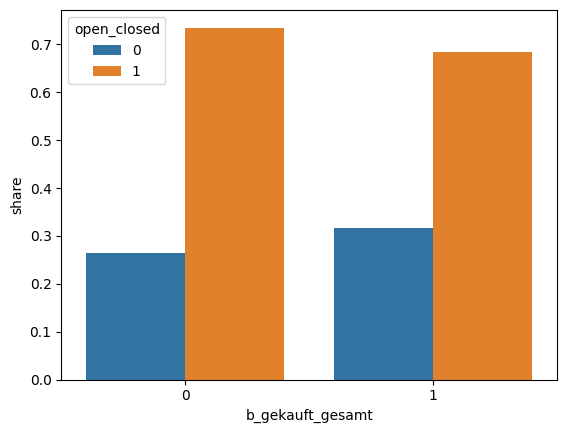

In [16]:
df['open_closed'] = np.where(df['q_openinghours'] == 0, 0, 1)

df[['open_closed', 'b_gekauft_gesamt']] \
    .value_counts() \
    .reset_index(name='count') \
    .merge(
        df[['b_gekauft_gesamt']].value_counts().reset_index(name='count'),
        on='b_gekauft_gesamt'
    ) \
    .assign(share = lambda x: x['count_x'] / x['count_y']) \
    .pipe((sns.barplot, 'data'), x='b_gekauft_gesamt', y='share', hue='open_closed')

seems like the share of the customers with opening hours is about the same as the share for the two target groups

let's calculate share of expenses on medical products as part of expenses on personal care and purchasing power per average household size


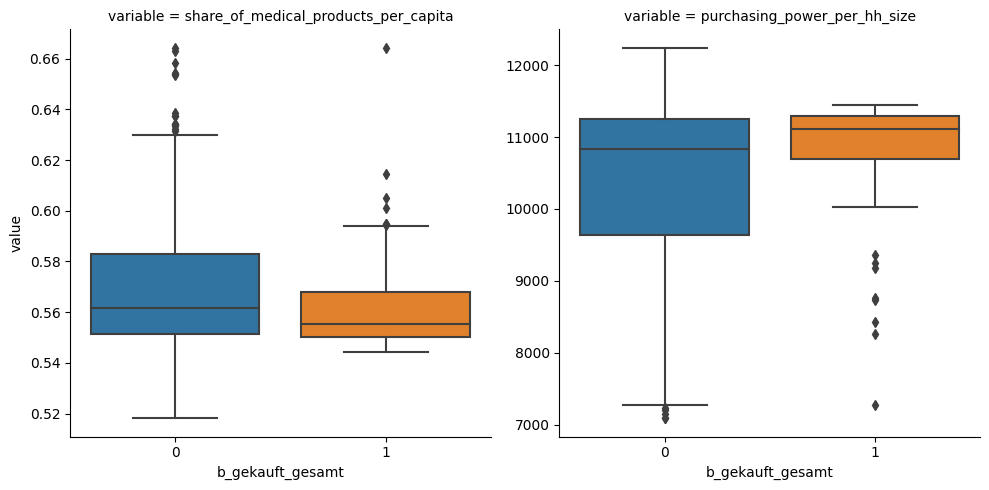

In [17]:
df['share_of_medical_products_per_capita'] = df['q_2017_medical_products_per_capita'] / df['q_2017_personal_care_per_capita']
df['purchasing_power_per_hh_size'] = df['q_2017_purchasing_power_per_capita'] / df['q_2017_average_household_size']


df[['share_of_medical_products_per_capita', 'purchasing_power_per_hh_size', 'b_gekauft_gesamt']] \
    .melt(id_vars='b_gekauft_gesamt') \
    .pipe(
        (sns.catplot, 'data'), 
        x='b_gekauft_gesamt', y='value', col='variable', kind='box', sharey=False
    )

### Modeling

Let's split the labeled data into train and test sets. The train set will be used for model building and optimization (feature selection, hyperparameter optimization, etc.), while the test set will be used for the filnal model performance evoluation. Also as the target variable is highly imbalanced, I will use the stratify option to have the same share of the target classes in the train and test splits

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['b_gekauft_gesamt', 'fakeid', 'b_in_kontakt_gewesen']), 
    df['b_gekauft_gesamt'],
    stratify=df['b_gekauft_gesamt'],
    shuffle=True,
    random_state=seed,
    test_size=0.1
)

In [19]:
print(
    "train target:\n", y_train.value_counts(normalize=True), "\n",
    "test target:\n", y_test.value_counts(normalize=True)
)

train target:
 0    0.984978
1    0.015022
Name: b_gekauft_gesamt, dtype: float64 
 test target:
 0    0.984127
1    0.015873
Name: b_gekauft_gesamt, dtype: float64


Let's define a cross validation scheme. Similar to the train and test splits I want my cross-validation splits to have the same share of the target classes. As such I will go for StratifiedKFold. Also, as the number of the positive classes is very low in the data, I will set the number of splits to 3 to have (more or less) enough samples of the positive class in each split

Also, let's create metrics to evaluate the performance of the model

In [20]:
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

scoring = {
    'recall_positive_class': make_scorer(recall_score, average='binary'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'precision_positive_class': make_scorer(
        precision_score, average='binary', zero_division=0
    ),
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0)
}

let's start with a logistic regression as a baseline model

We know that variable "q_opening_hours" contains one missing value and as logistic regression does not handle missing values natively, we will have to impute that missing value. As there is only one missing value I will opt for simple imputation

In [21]:
log_reg = make_pipeline(
    SimpleImputer(),
    LogisticRegression(max_iter=1000, random_state=seed)
)

scores = cross_validate(
    log_reg, X_train, y_train, cv=folds, scoring=scoring, return_train_score=True
)
scores

{'fit_time': array([0.05709219, 0.03030205, 0.02895999]),
 'score_time': array([0.00771976, 0.00779223, 0.00863385]),
 'test_recall_positive_class': array([0., 0., 0.]),
 'train_recall_positive_class': array([0., 0., 0.]),
 'test_recall_macro': array([0.5, 0.5, 0.5]),
 'train_recall_macro': array([0.5, 0.5, 0.5]),
 'test_precision_positive_class': array([0., 0., 0.]),
 'train_precision_positive_class': array([0., 0., 0.]),
 'test_precision_macro': array([0.49249117, 0.49249117, 0.49248453]),
 'train_precision_macro': array([0.49248785, 0.49248785, 0.49249117])}

seems like the logistic regression model can't identify positive classes at all. Let's try a different model in both train and test sets

In [22]:
xgb_clf = XGBClassifier(random_state=seed)
scores = cross_validate(
    xgb_clf, X_train, y_train, cv=folds, scoring=scoring, return_train_score=True
)
scores

{'fit_time': array([0.45036173, 0.14653492, 0.12893581]),
 'score_time': array([0.01045704, 0.0080502 , 0.00824094]),
 'test_recall_positive_class': array([0., 0., 0.]),
 'train_recall_positive_class': array([0.97058824, 1.        , 1.        ]),
 'test_recall_macro': array([0.5       , 0.49955157, 0.4986535 ]),
 'train_recall_macro': array([0.98529412, 1.        , 1.        ]),
 'test_precision_positive_class': array([0., 0., 0.]),
 'train_precision_positive_class': array([1., 1., 1.]),
 'test_precision_macro': array([0.49249117, 0.49248453, 0.49246454]),
 'train_precision_macro': array([0.99977578, 1.        , 1.        ])}

seems like xgboost identifies both classes almost perfectly in the train set, however, cannot identify positive classes in the test set meaning that it overfits to the training set

let's set weighting for the target classes and try the model again

In [23]:
pos_weight = np.sum(y_train==0) / np.sum(y_train==1)
print(pos_weight)

65.56862745098039


In [24]:
xgb_clf = XGBClassifier(scale_pos_weight=pos_weight, random_state=seed)
scores = cross_validate(
    xgb_clf, X_train, y_train, cv=folds, scoring=scoring, return_train_score=True
)
scores

{'fit_time': array([0.16581893, 0.13857794, 0.17315817]),
 'score_time': array([0.00796604, 0.0079782 , 0.00955296]),
 'test_recall_positive_class': array([0., 0., 0.]),
 'train_recall_positive_class': array([1., 1., 1.]),
 'test_recall_macro': array([0.49910314, 0.49596413, 0.49775583]),
 'train_recall_macro': array([0.99977568, 1.        , 1.        ]),
 'test_precision_positive_class': array([0., 0., 0.]),
 'train_precision_positive_class': array([0.97142857, 1.        , 1.        ]),
 'test_precision_macro': array([0.49247788, 0.49243099, 0.49245115]),
 'train_precision_macro': array([0.98571429, 1.        , 1.        ])}

The model still overfits to the training set. Some strategies to deal with overfitting are:
- reducing complexity of the model (choosing a simpler model, reducing the number of features, etc)
- adding more training data

Let's try to reduce the complexity of the model through feature selection. We can do that with RFECV class from sklearn that does Recursive feature elimination with cross-validation. We can then still use our stratified cross-validation scheme

In [25]:
rfecv = RFECV(
    estimator=XGBClassifier(scale_pos_weight=pos_weight, random_state=seed),
    step=1,
    cv=folds,
    scoring=make_scorer(recall_score, average='macro'),
    min_features_to_select=2,
    n_jobs=2,
)
rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")
optimal_features = X_train.columns[rfecv.support_].tolist()
print(f"Optimal feature are: {optimal_features}")

Optimal number of features: 2
Optimal feature are: ['b_specialisation_h', 'b_specialisation_f']


Let's try the model with the selected features only

In [26]:
scores = cross_validate(
    XGBClassifier(scale_pos_weight=pos_weight, random_state=seed), 
    X_train[optimal_features], 
    y_train, 
    cv=folds, 
    scoring=scoring, 
    return_train_score=True
)
scores

{'fit_time': array([0.06471896, 0.03355503, 0.04093313]),
 'score_time': array([0.00780082, 0.00760579, 0.00748992]),
 'test_recall_positive_class': array([0.41176471, 0.23529412, 0.29411765]),
 'train_recall_positive_class': array([0.26470588, 0.35294118, 0.32352941]),
 'test_recall_macro': array([0.65162226, 0.56876814, 0.58871053]),
 'train_recall_macro': array([0.57874146, 0.62016731, 0.6101952 ]),
 'test_precision_positive_class': array([0.0546875 , 0.03539823, 0.03703704]),
 'train_precision_positive_class': array([0.03629032, 0.04562738, 0.04564315]),
 'test_precision_macro': array([0.52236367, 0.51132031, 0.51249442]),
 'train_precision_macro': array([0.51194169, 0.51731369, 0.51713695])}

Seems like we have dealt with the overfitting problem and the model identifies some positive classes as well. However, the overall performance of the model is not optimal and it varies from a split to split. This is probably due to varying distribtuion of the feature values across the splits. Also, as we selected the optimal features based on recall only, precision suffered from it. This means that there are many false positives among the model predictions meaning that with such a model most of the identified leads will not convert.

Let's train our final model on the complete train set and evaluate the performance on the test set

In [27]:
xgb_clf = XGBClassifier(scale_pos_weight=pos_weight, random_state=seed)
xgb_clf.fit(X_train[optimal_features], y_train)
y_test_pred = xgb_clf.predict(X_test[optimal_features])

print(f'recall: {recall_score(y_test, y_test_pred, average=None)}')
print(f'precision: {precision_score(y_test, y_test_pred, average=None)}')

recall: [0.88978495 0.66666667]
precision: [0.99399399 0.08888889]


Overall, our model is suboptimal, which mostly due to the fact the data is highly imbalanced. Some options to improve the model performance are:

- collecting more data
- upsampling the positive class
- generating better predictive features

Currently, it is worth considering whether such a model with this performance provides any value to the business and if it is better to actually randomly select customers for targeting. 